In [4]:
import random
import tempfile
from pathlib import Path
import pandas as pd
from datasetsforecast.m4 import M4
from utilsforecast.plotting import plot_series
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from numba import njit
from window_ops.rolling import rolling_mean
from mlforecast.target_transforms import LocalStandardScaler

@njit
def rolling_mean_48(x):
    return rolling_mean(x, window_size=48)
    

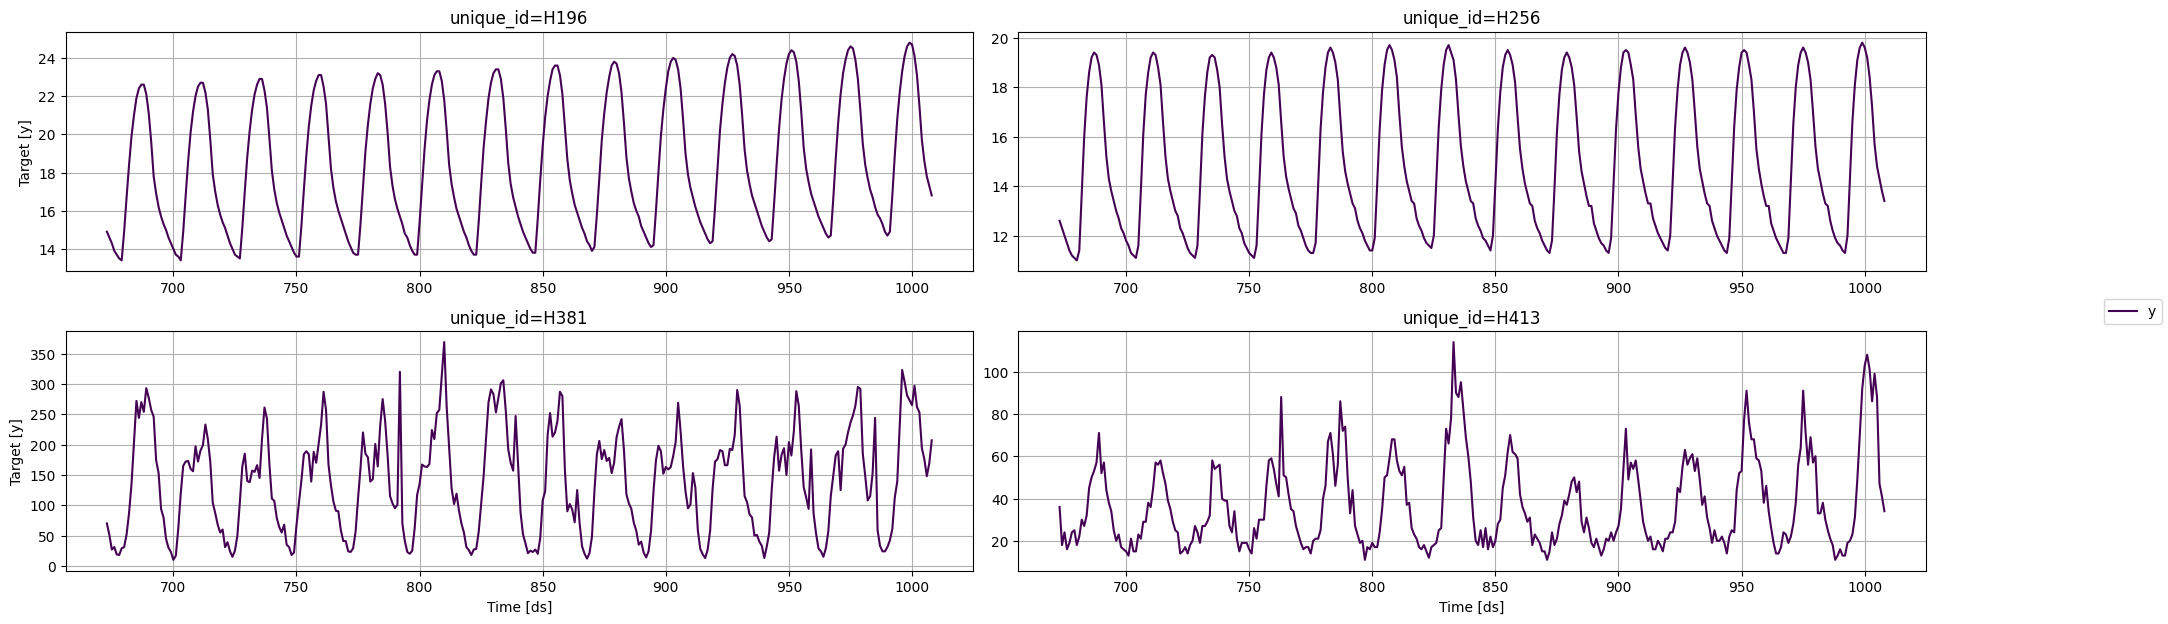

In [5]:
await M4.async_download('data', group='Hourly')
df, *_ = M4.load('data', 'Hourly')
uids = df['unique_id'].unique()
random.seed(0)
sample_uids = random.choices(uids, k=4)
df = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
df['ds'] = df['ds'].astype('int64')
fig = plot_series(df, max_insample_length=24 * 14)
fig

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from mlforecast.utils import PredictionIntervals

fcst = MLForecast(
    models=[LinearRegression(), RandomForestRegressor(), SVR(kernel='rbf')],
    freq=1,
    target_transforms=[Differences([24])],
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    }
    #date_features=[hour_index],
)
fcst.fit(df)

MLForecast(models=[LinearRegression, RandomForestRegressor, SVR], freq=1, lag_features=['lag1', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=[], num_threads=1)

In [22]:
preds = fcst.predict(48)
preds.head()

unique_id    ds  LinearRegression  RandomForestRegressor        SVR
0      H196  1009         16.322220                 16.313  16.270269
1      H196  1010         15.935549                 15.908  15.858513
2      H196  1011         15.724612                 15.729  15.617848
3      H196  1012         15.418013                 15.476  15.301313
4      H196  1013         15.032886                 15.067  14.930382

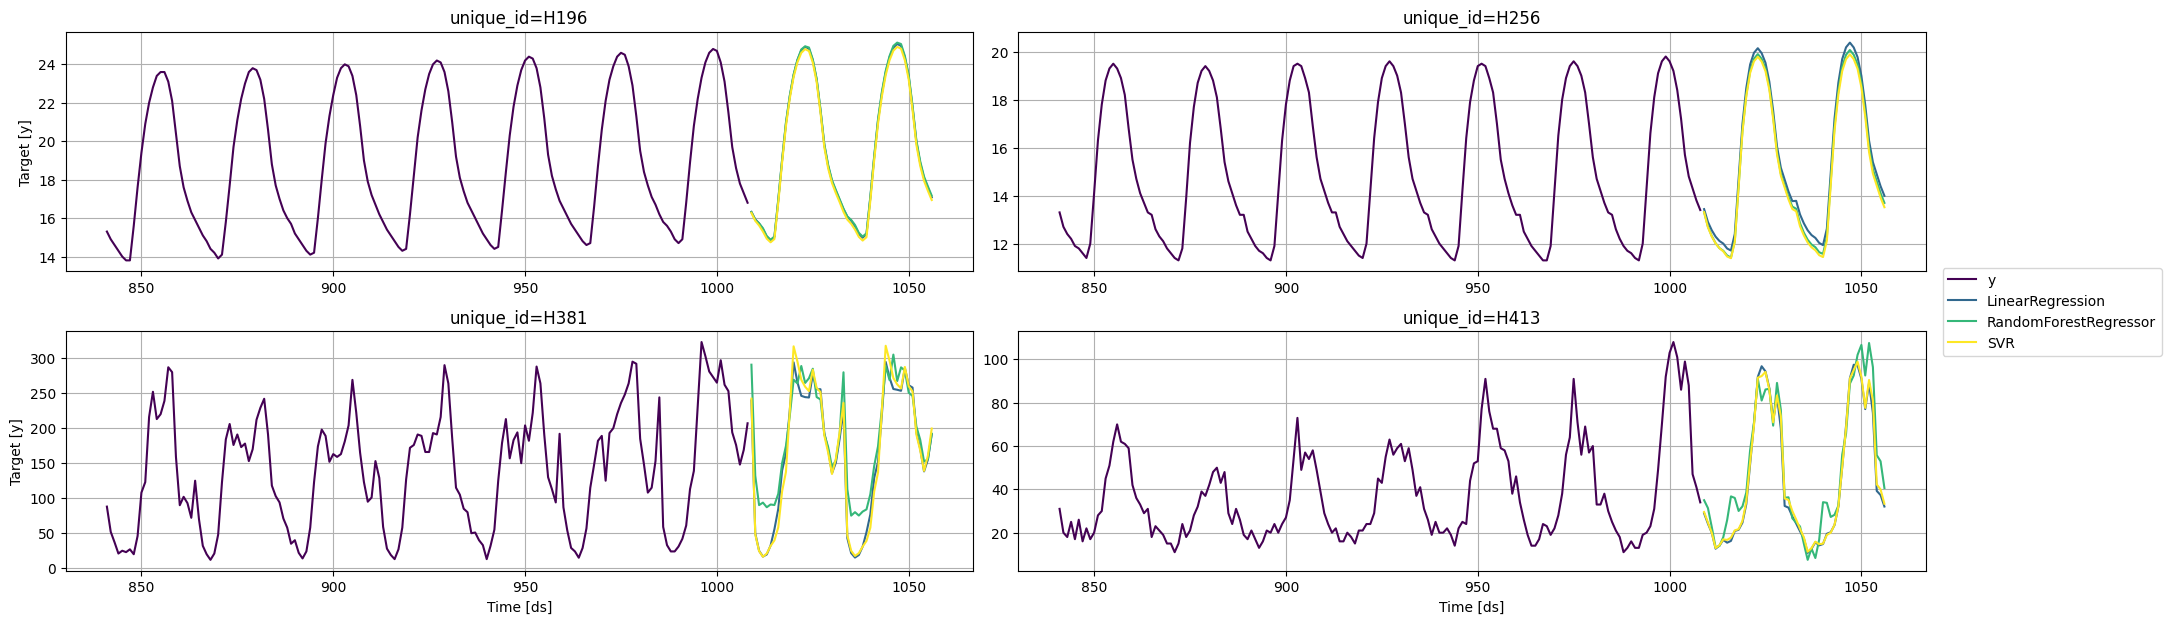

In [23]:
fig = plot_series(df, preds, max_insample_length=24 * 7)
fig

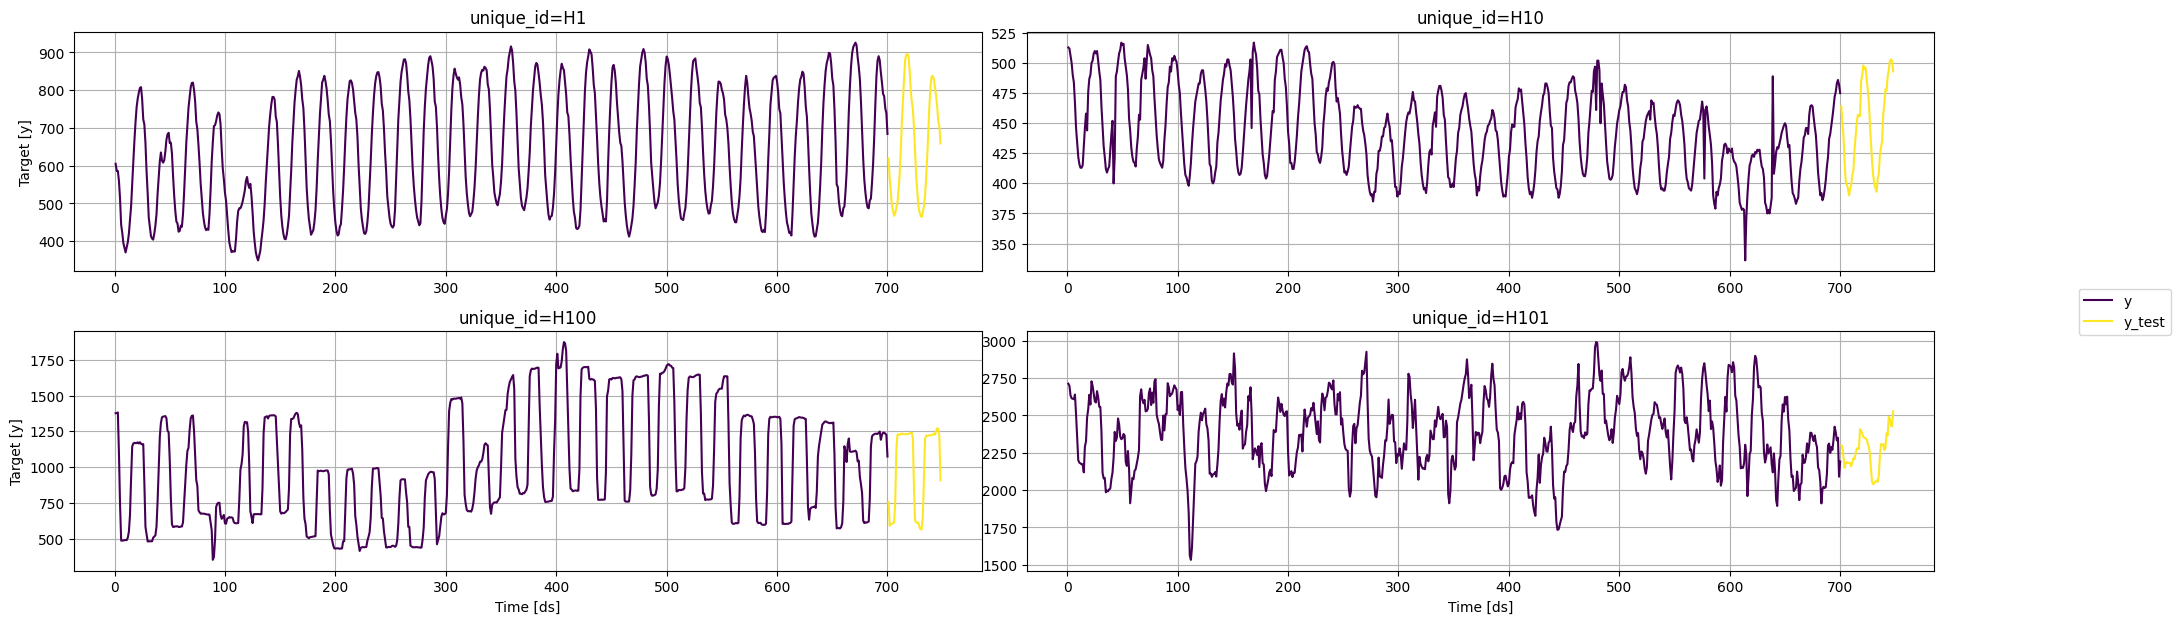

In [26]:
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv')

n_series = 4 
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

fig = plot_series(train, test.rename(columns={'y': 'y_test'}), models=['y_test'], plot_random=False)
fig

## Train several ML models

In [77]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 

# Create a list of models and instantiation parameters 
models = [Ridge(), Lasso(), LinearRegression(), 
          KNeighborsRegressor(), MLPRegressor(random_state=0, max_iter=500), 
          RandomForestRegressor(n_estimators=500, max_depth=4, random_state=0), 
          SVR(), 
          GradientBoostingRegressor(n_estimators=500, max_depth=4, random_state=0)]

mlf = MLForecast(
    models=models,
    freq=1,
    target_transforms=[Differences([24])],
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    }
)
# mlf.fit(train)
mlf.fit(train, prediction_intervals=PredictionIntervals(n_windows=10, h=48))

/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLForecast(models=[Ridge, Lasso, LinearRegression, KNeighborsRegressor, MLPRegressor, RandomForestRegressor, SVR, GradientBoostingRegressor], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=[], num_threads=1)

## Predictions

In [78]:
levels = [50, 80, 95]
forecasts = mlf.predict(48, level=levels)
forecasts.head()

unique_id   ds       Ridge       Lasso  LinearRegression  \
0        H1  701  674.502068  674.488972        674.502083   
1        H1  702  603.355946  603.329288        603.355965   
2        H1  703  555.281491  555.253012        555.281516   
3        H1  704  522.181340  522.148450        522.181368   
4        H1  705  498.895122  498.859451        498.895153   

   KNeighborsRegressor  MLPRegressor  RandomForestRegressor         SVR  \
0                626.6    659.287959             686.540624  694.236282   
1                611.6    539.753255             613.653016  617.812251   
2                507.0    553.280466             558.540624  566.176526   
3                506.0    517.258383             524.540624  531.226339   
4                487.8    494.389572             499.540624  506.054022   

   GradientBoostingRegressor  ...   SVR-lo-50   SVR-hi-50   SVR-hi-80  \
0                 639.361027  ...  663.085379  725.387185  766.195704   
1                 568.392268  ...  600.488150  635.136353  648.173937   
2                 527.445458  ...  542.031125  590.321926  627.401990   
3                 491.461437  ...  509.559348  552.893330  585.878384   
4                 466.018320  ...  486.914068  525.193975  551.189602   

    SVR-hi-95  GradientBoostingRegressor-lo-95  \
0  788.091551                       552.446318   
1  697.515622                       498.544621   
2  644.715212                       448.705754   
3  598.814447                       422.644329   
4  570.805136                       400.936660   

   GradientBoostingRegressor-lo-80  GradientBoostingRegressor-lo-50  \
0                       561.538207                       591.090957   
1                       511.012318                       543.834566   
2                       462.082832                       487.398225   
3                       431.405387                       453.898475   
4                       420.045945                       440.666520   

   GradientBoostingRegressor-hi-50  GradientBoostingRegressor-hi-80  \
0                       687.631097                       717.183848   
1                       592.949969                       625.772218   
2                       567.492691                       592.808084   
3                       529.024400                       551.517488   
4                       491.370120                       511.990694   

   GradientBoostingRegressor-hi-95  
0                       726.275737  
1                       638.239915  
2                       606.185162  
3                       560.278546  
4                       531.099980  

[5 rows x 58 columns]

## Join predictions to test

In [79]:
test2 = test.merge(forecasts, how='left', on=['unique_id', 'ds'])
test2.head()

unique_id   ds      y       Ridge       Lasso  LinearRegression  \
0        H1  701  619.0  674.502068  674.488972        674.502083   
1        H1  702  565.0  603.355946  603.329288        603.355965   
2        H1  703  532.0  555.281491  555.253012        555.281516   
3        H1  704  495.0  522.181340  522.148450        522.181368   
4        H1  705  481.0  498.895122  498.859451        498.895153   

   KNeighborsRegressor  MLPRegressor  RandomForestRegressor         SVR  ...  \
0                626.6    659.287959             686.540624  694.236282  ...   
1                611.6    539.753255             613.653016  617.812251  ...   
2                507.0    553.280466             558.540624  566.176526  ...   
3                506.0    517.258383             524.540624  531.226339  ...   
4                487.8    494.389572             499.540624  506.054022  ...   

    SVR-lo-50   SVR-hi-50   SVR-hi-80   SVR-hi-95  \
0  663.085379  725.387185  766.195704  788.091551   
1  600.488150  635.136353  648.173937  697.515622   
2  542.031125  590.321926  627.401990  644.715212   
3  509.559348  552.893330  585.878384  598.814447   
4  486.914068  525.193975  551.189602  570.805136   

   GradientBoostingRegressor-lo-95  GradientBoostingRegressor-lo-80  \
0                       552.446318                       561.538207   
1                       498.544621                       511.012318   
2                       448.705754                       462.082832   
3                       422.644329                       431.405387   
4                       400.936660                       420.045945   

   GradientBoostingRegressor-lo-50  GradientBoostingRegressor-hi-50  \
0                       591.090957                       687.631097   
1                       543.834566                       592.949969   
2                       487.398225                       567.492691   
3                       453.898475                       529.024400   
4                       440.666520                       491.370120   

   GradientBoostingRegressor-hi-80  GradientBoostingRegressor-hi-95  
0                       717.183848                       726.275737  
1                       625.772218                       638.239915  
2                       592.808084                       606.185162  
3                       551.517488                       560.278546  
4                       511.990694                       531.099980  

[5 rows x 59 columns]

## Plot predictions

### Ridge predictions

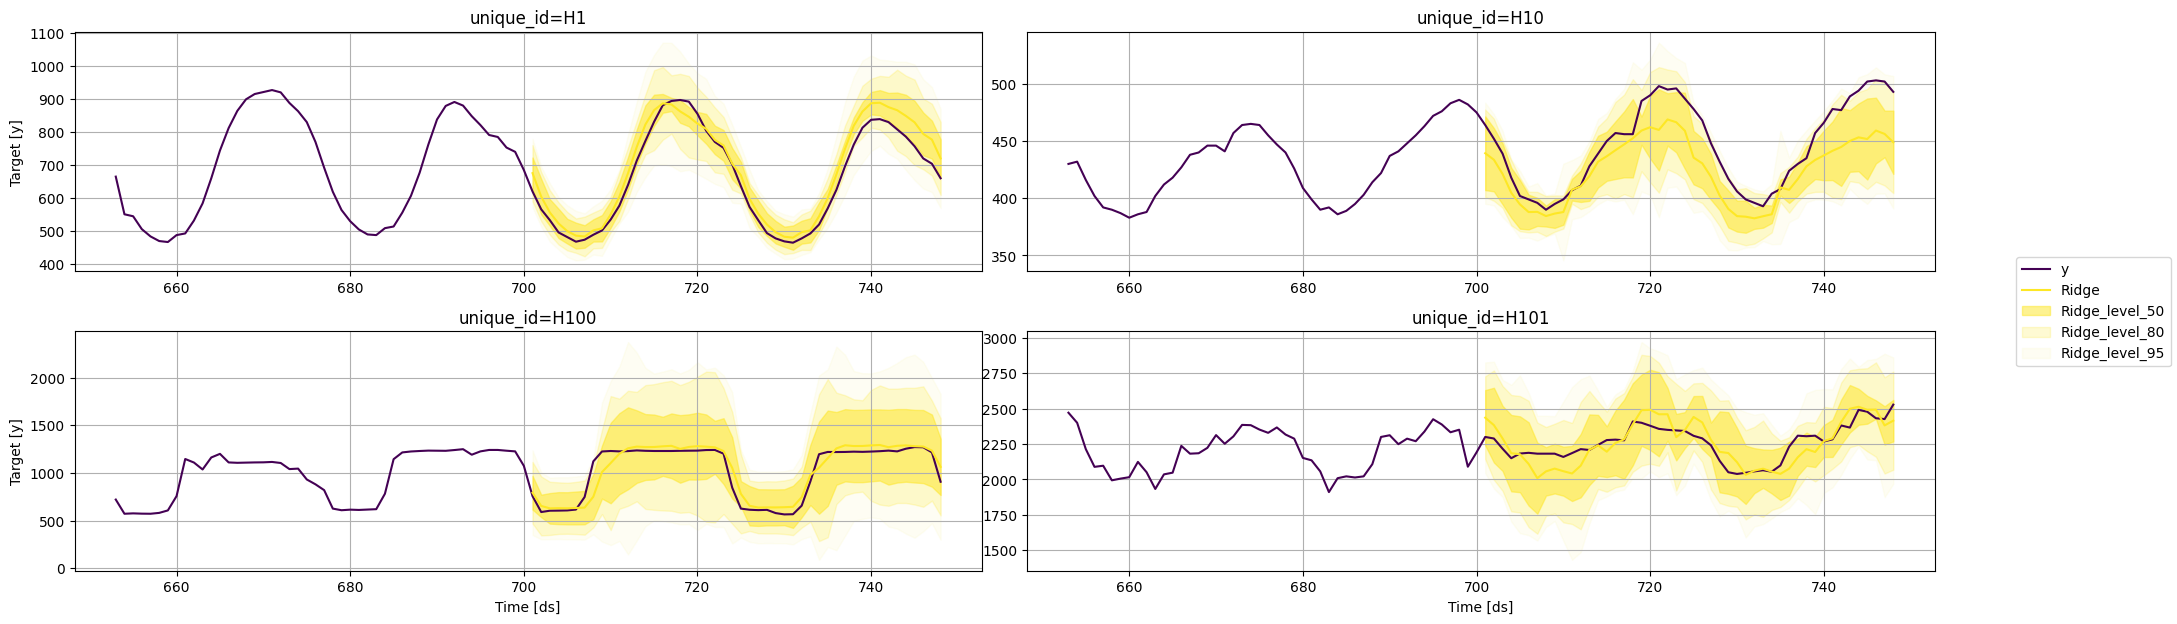

In [82]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['Ridge'], 
    level=levels, 
    max_insample_length=48
)
fig

### Lasso predictions

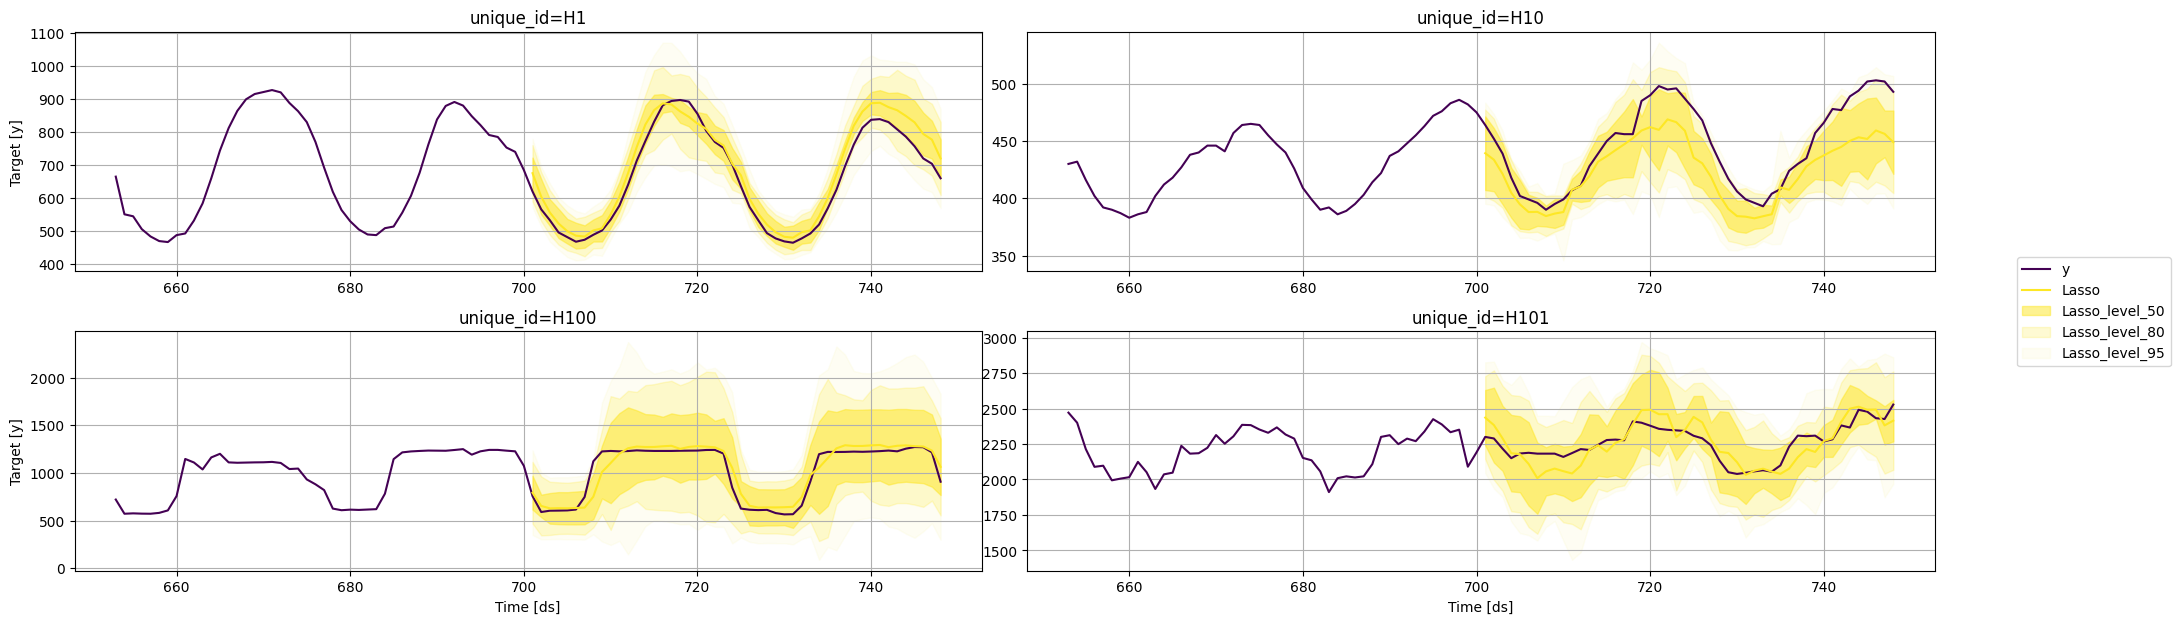

In [80]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['Lasso'], 
    level=levels, 
    max_insample_length=48
)
fig

### Standard LinearRegression predictions

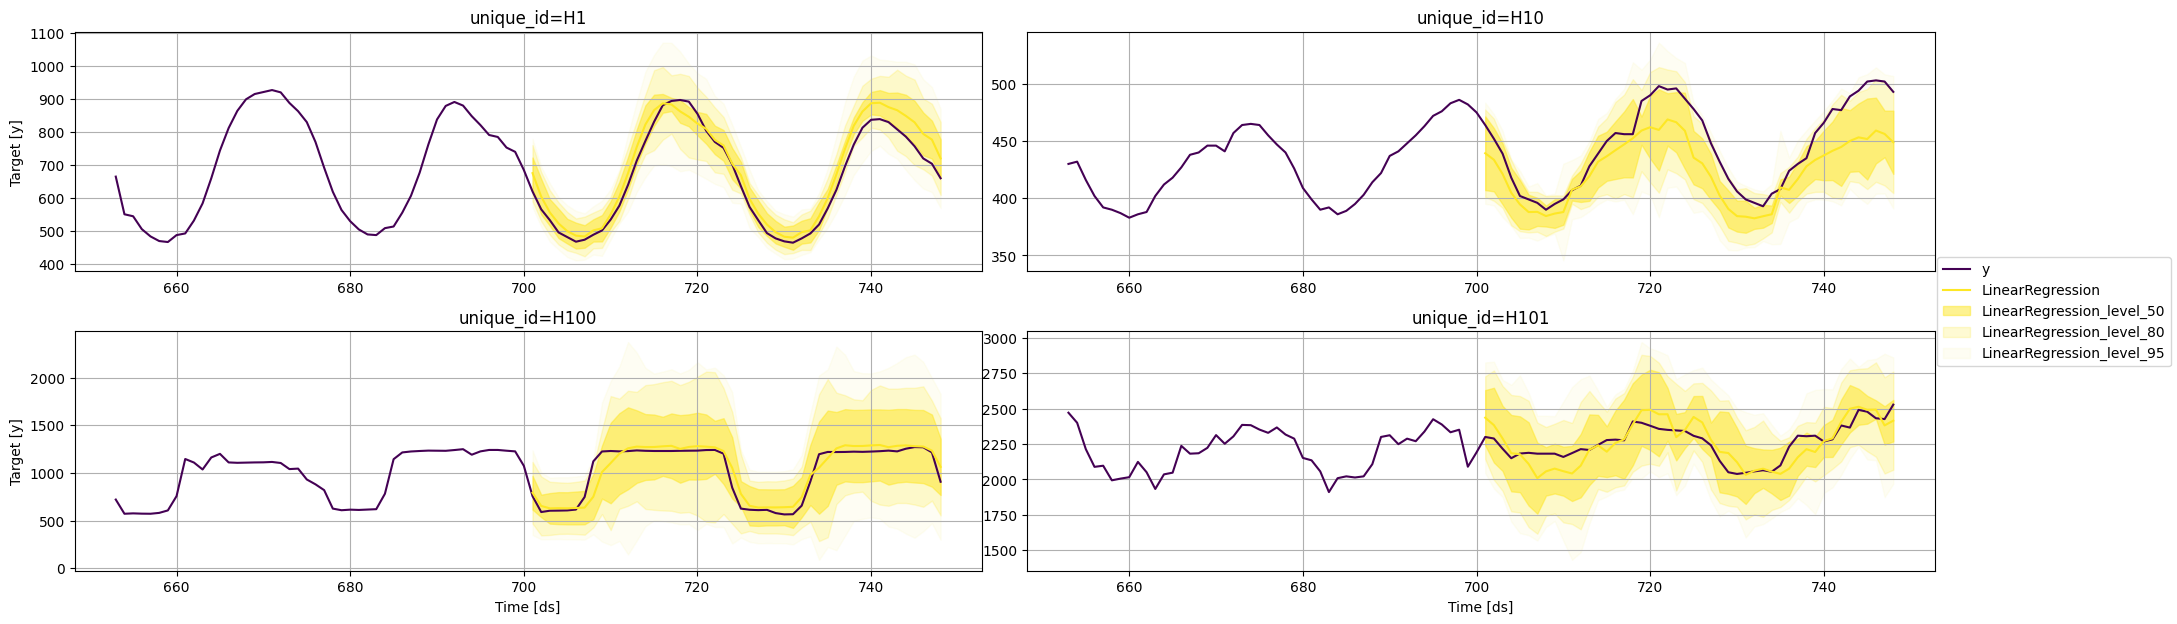

In [81]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['LinearRegression'], 
    level=levels, 
    max_insample_length=48
)
fig

### KNeighborsRegressor predictions

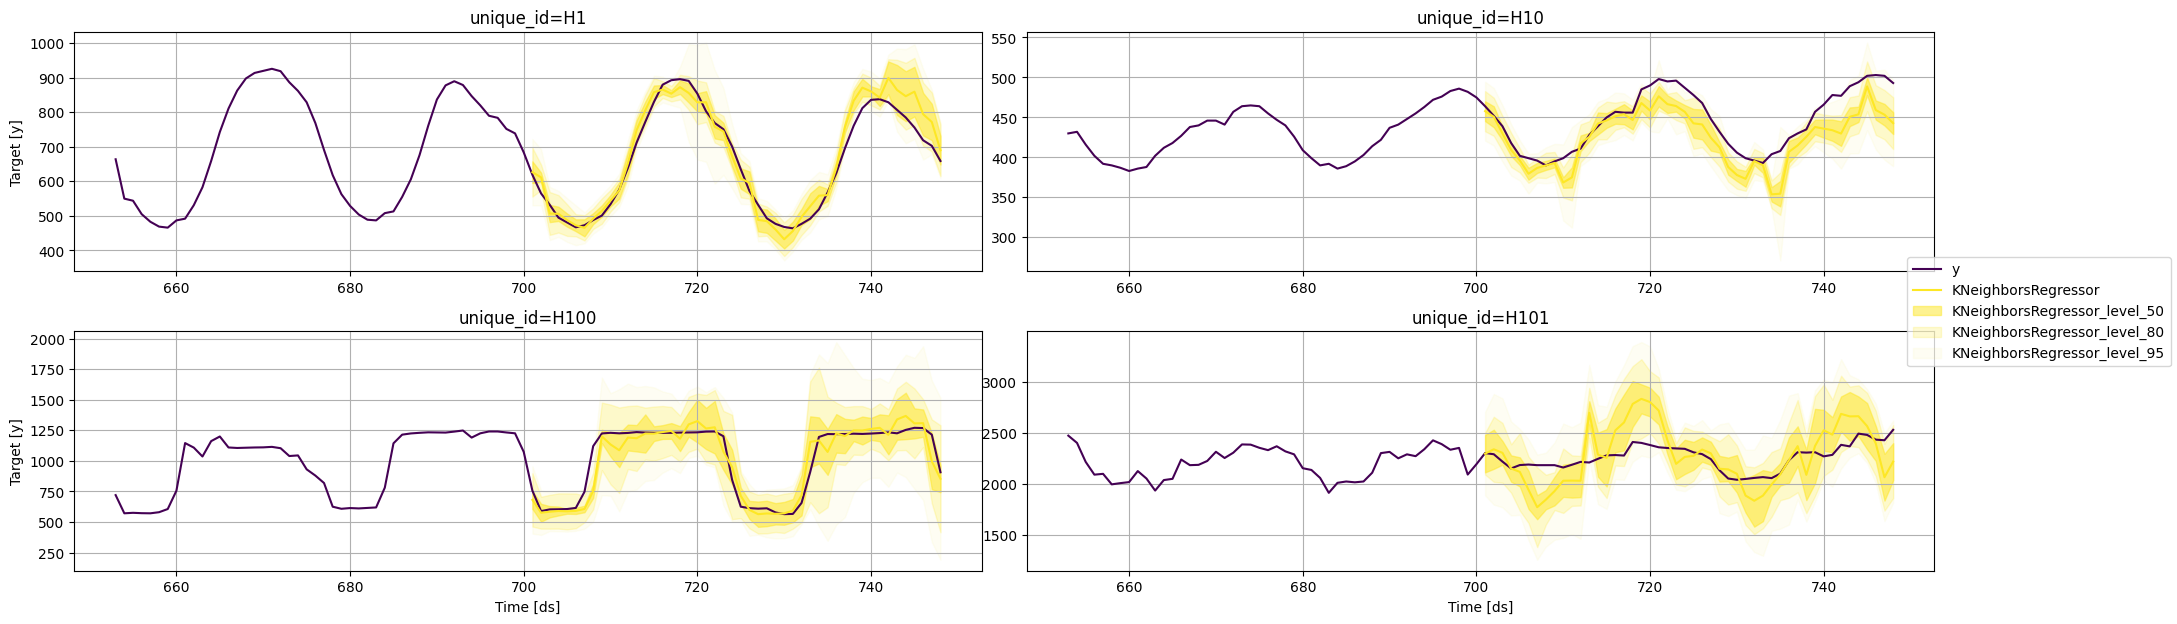

In [83]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['KNeighborsRegressor'], 
    level=levels, 
    max_insample_length=48
)
fig

### MLPRegressor predictions

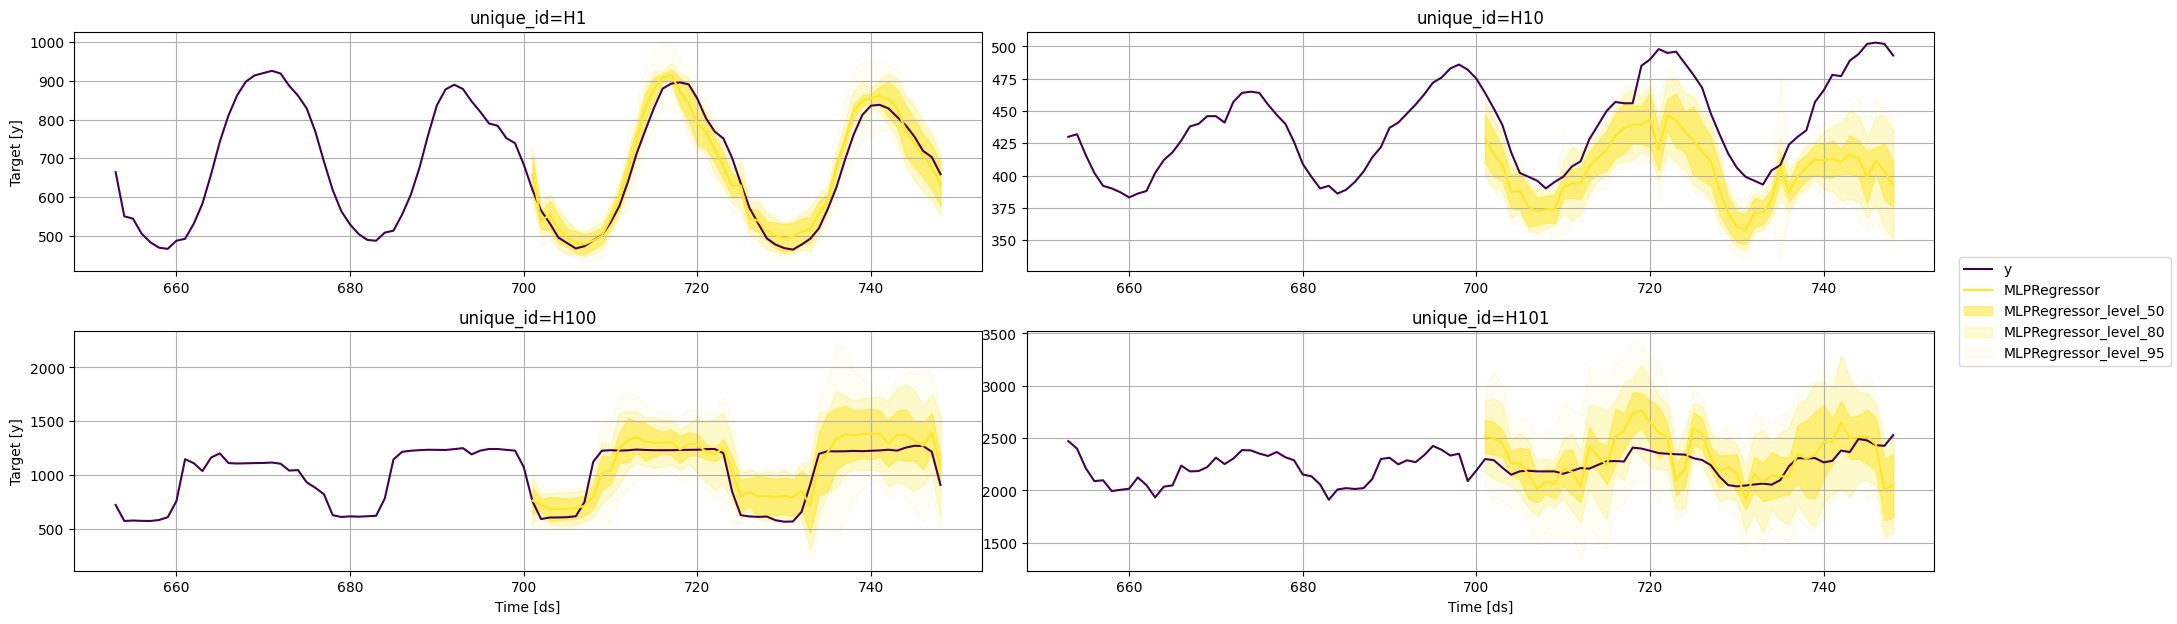

In [84]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['MLPRegressor'], 
    level=levels, 
    max_insample_length=48
)
fig

### RandomForestRegressor predictions

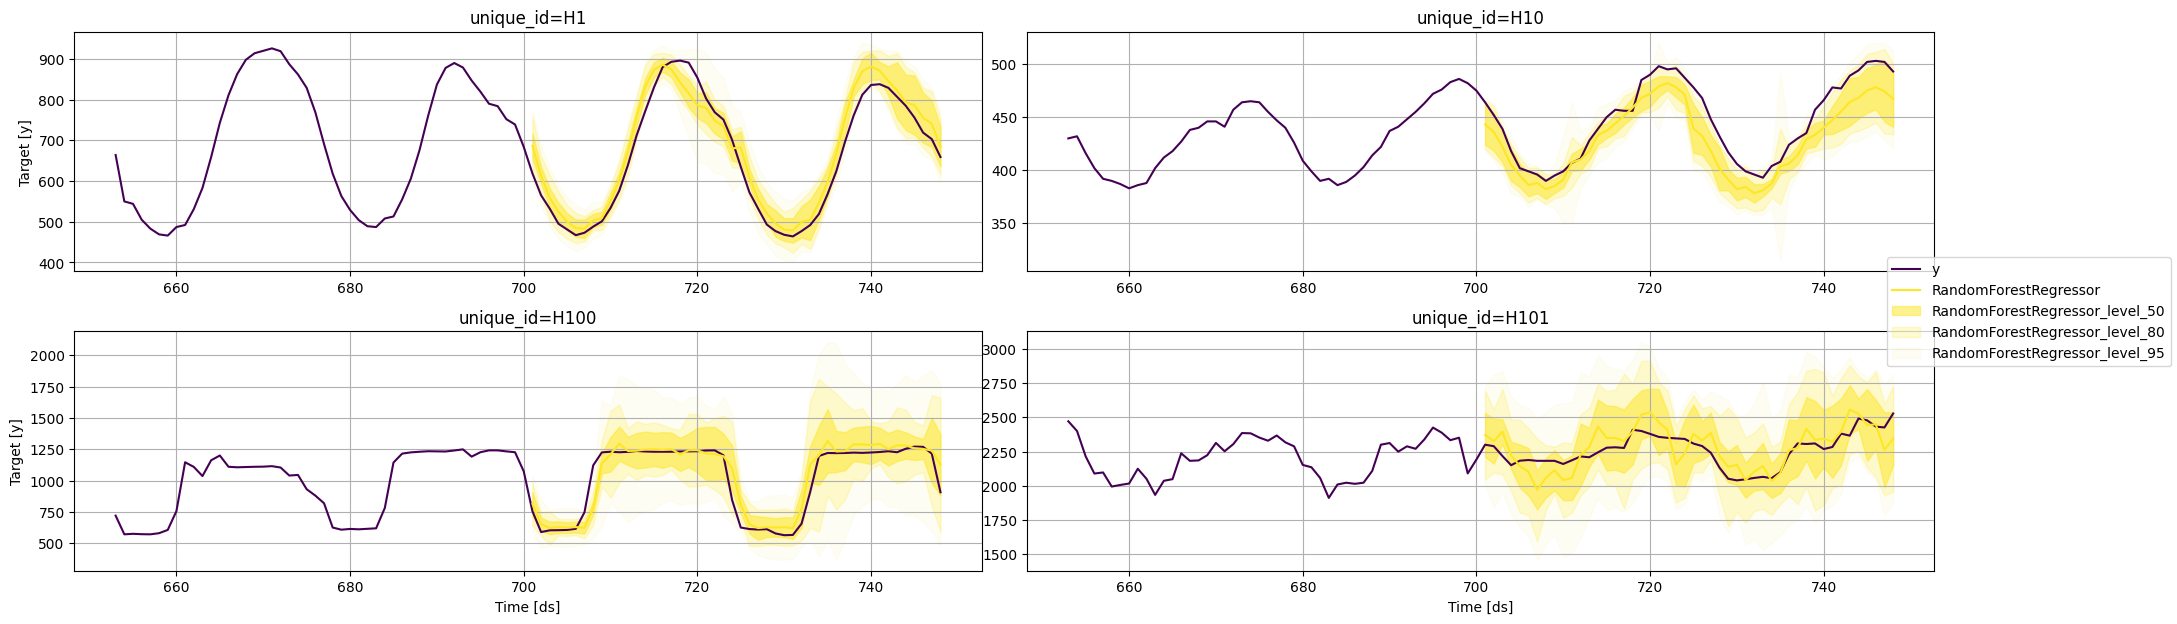

In [85]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['RandomForestRegressor'], 
    level=levels, 
    max_insample_length=48
)
fig

### SVR predictions

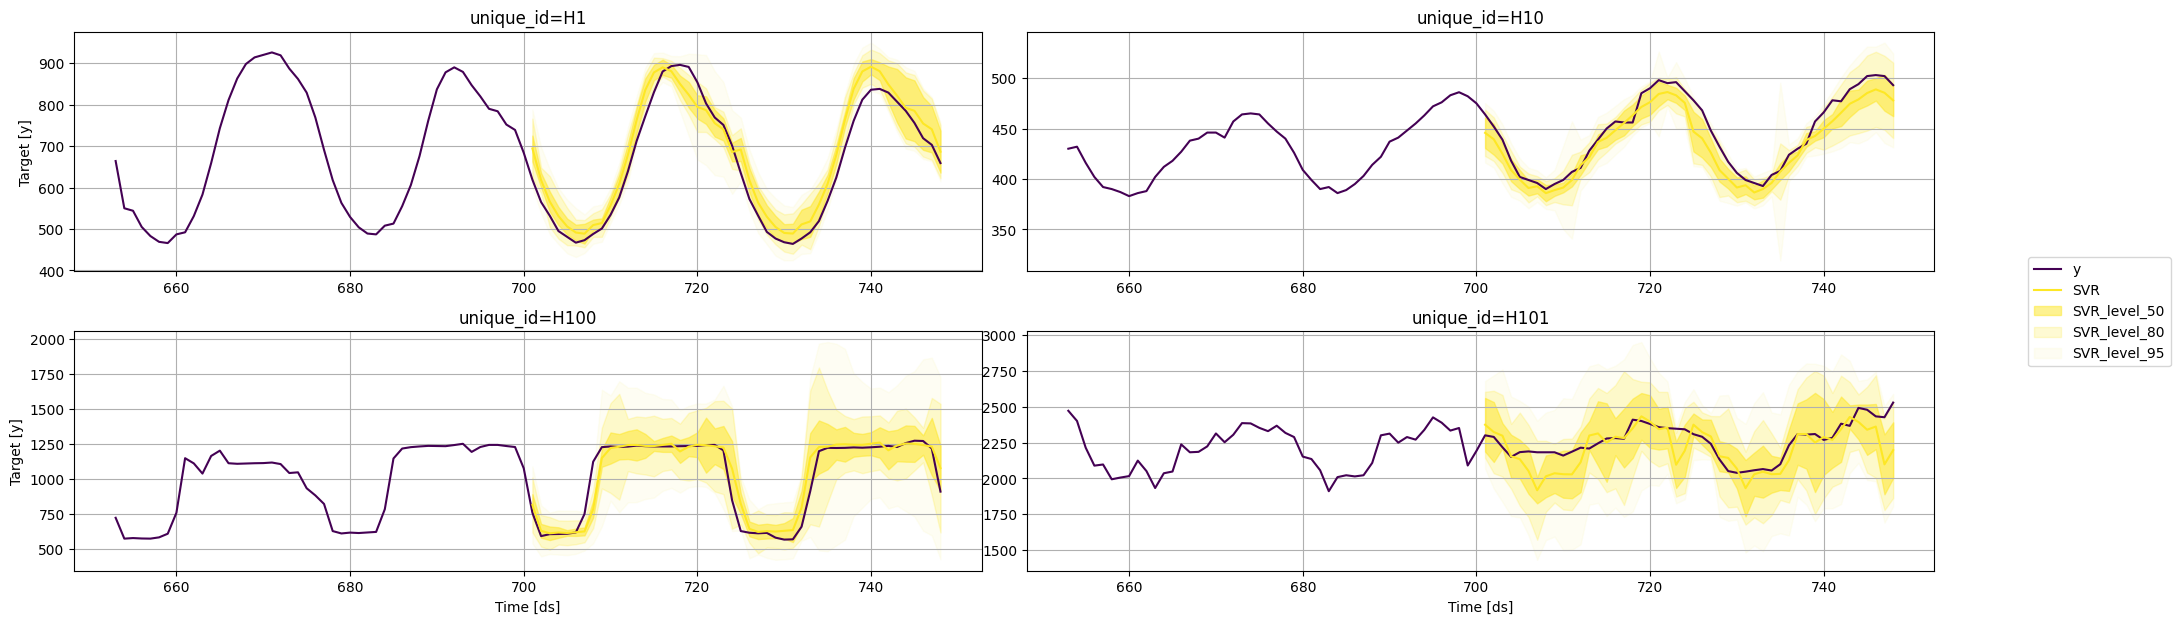

In [86]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['SVR'], 
    level=levels, 
    max_insample_length=48
)
fig

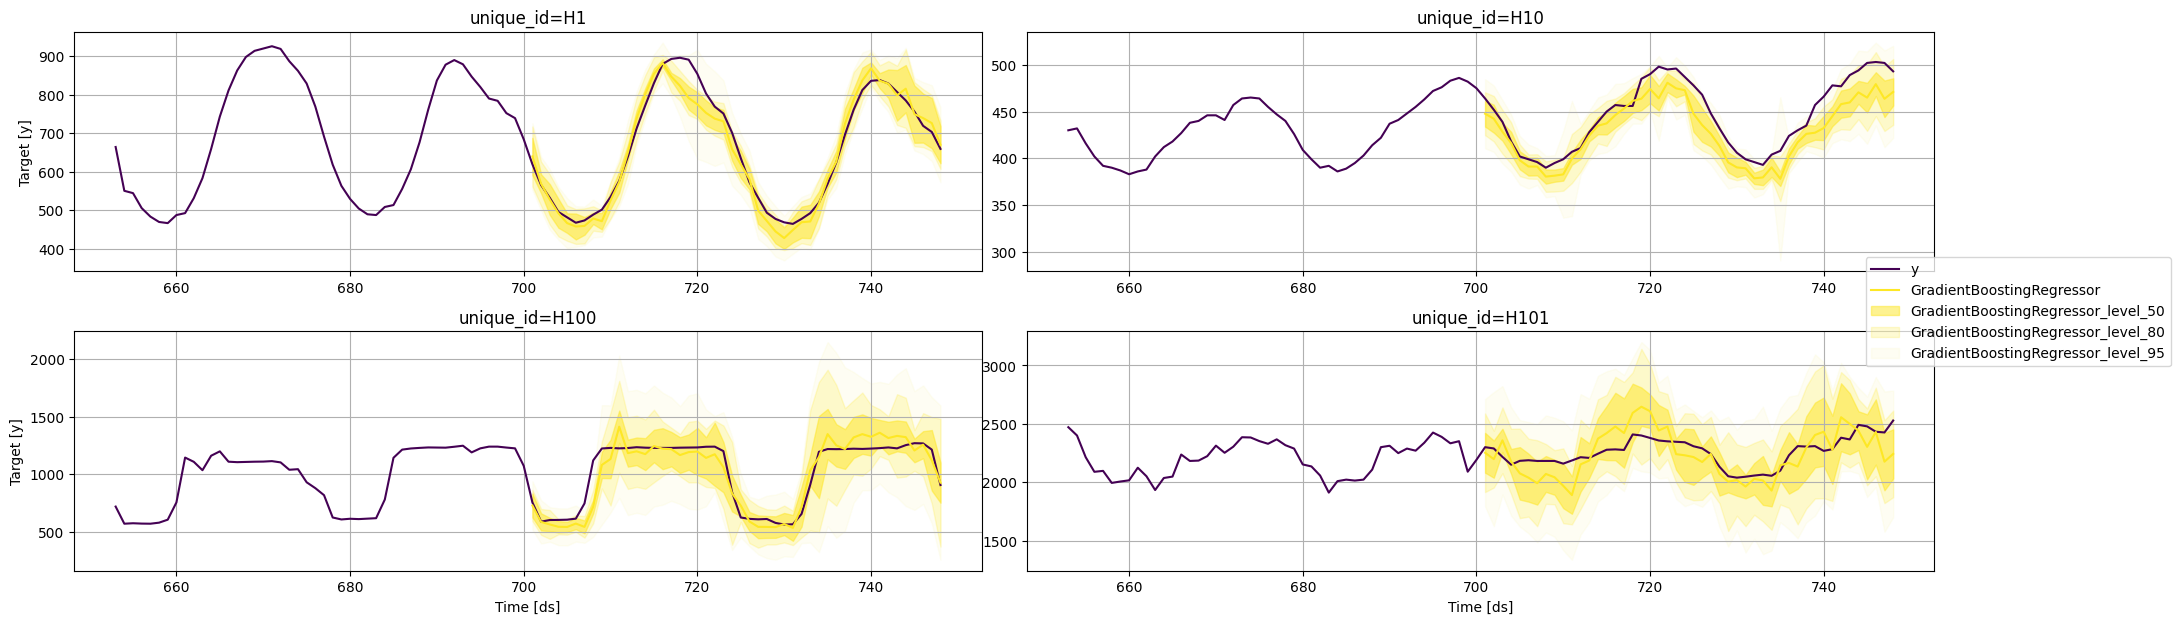

In [90]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['GradientBoostingRegressor'], 
    level=levels, 
    max_insample_length=48
)
fig

### Comparative plot models predictions

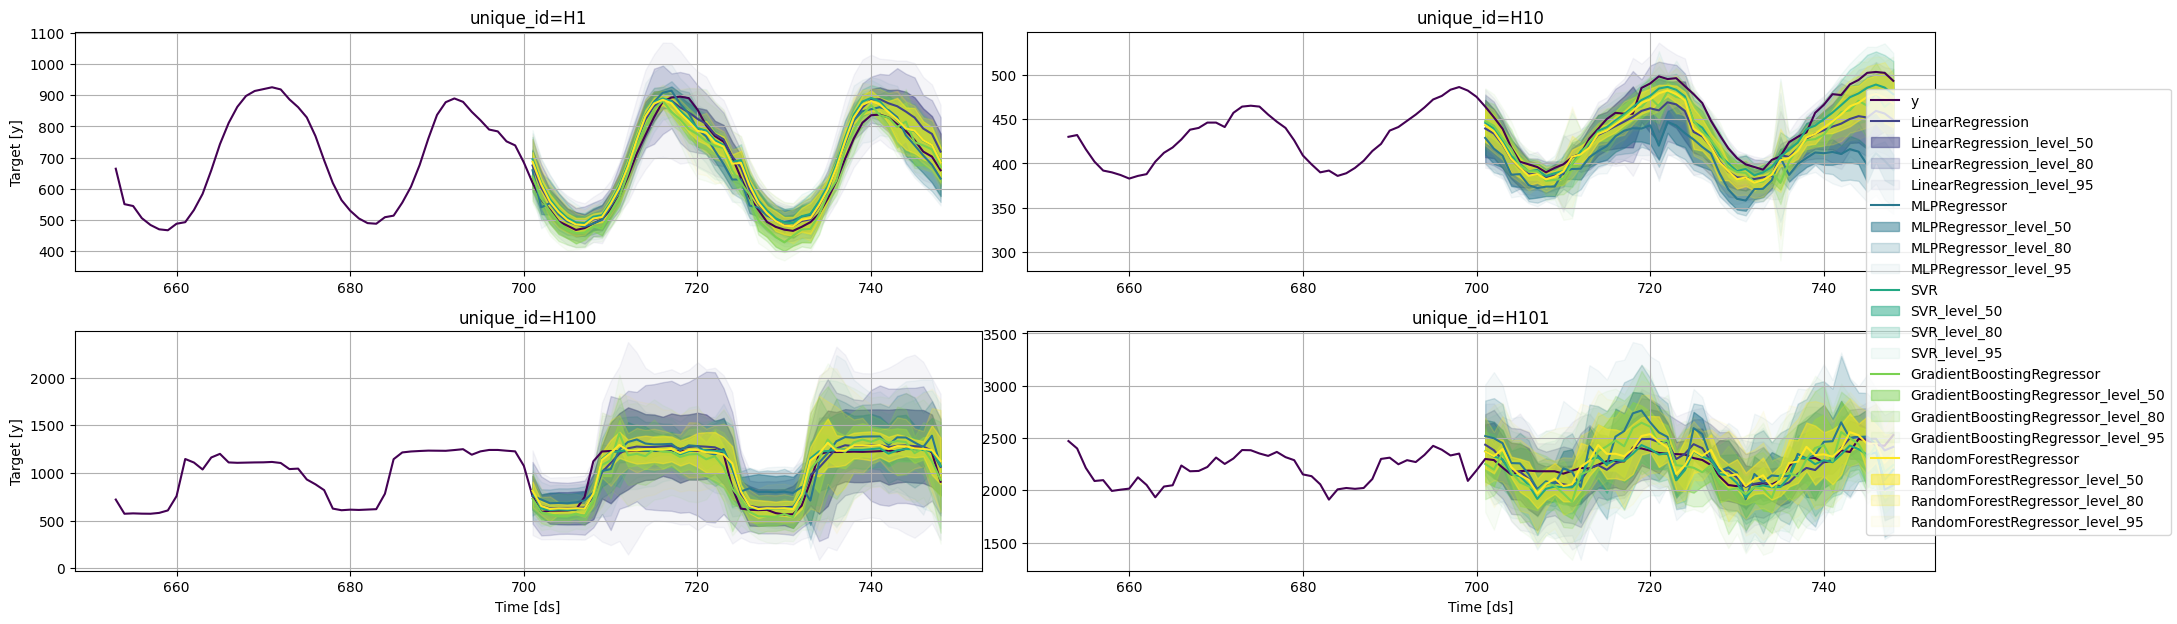

In [93]:
fig = plot_series(
    train, 
    test2, 
    plot_random=False, 
    models=['LinearRegression', 'MLPRegressor', 'SVR', 'GradientBoostingRegressor', 'RandomForestRegressor'], 
    level=levels, 
    max_insample_length=48
)
fig